In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTE

## Introduction:

The objective of this project is to analyze a dataset and predict whether a patient has had a stroke or not. Strokes can result in severe brain damage, long-term disability, or death, making it crucial to identify contributing factors and prevent their occurrence. In this project, we aim to build multiple machine learning models and determine the best-performing one based on the dataset.


## Data:

The dataset, obtained from kaggle.com (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset), includes 12 columns and 5110 rows with the following features: five categorical features (gender, ever_married, work_type, residence_type, and smoking_status), three numerical features (age, average glucose level, and body mass index), and three binary features (hypertension, heart disease, and stroke).

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The CDC states that a fasting blood sugar level of 99 mg/dL or less is considered normal, while a level between 100 and 125 mg/dL indicates prediabetes, and a level of 126 mg/dL or higher indicates diabetes. In addition, if an individual's BMI falls between 18.5 and 24.9, it is considered within the normal or healthy weight range.

## Data Cleaning:
To begin the data cleaning process, the first step was to remove the "id" column, as it was not relevant for our analysis.

Next, the dataset was checked for any null values, and it was found that there were 201 null values in the "bmi" column.

There are several ways to handle null values, such as filling them with the mean, zero, or dropping them altogether. For this project, the decision was made to use K Nearest Neighbor imputation to replace the null values with the closest estimated value. The "age" feature was used to estimate the missing "bmi" values for each individual.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df = df.iloc[:,1:]

In [7]:
# checking number of null counts
null_count = df.isnull().sum()
null_count

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

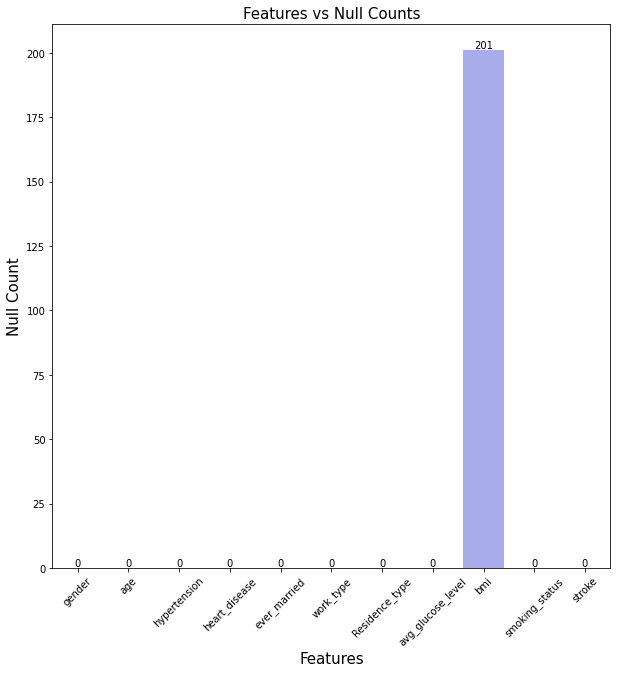

In [8]:
# plotting the features vs null counts
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=df.columns, y=null_count)
ax.bar_label(ax.containers[0])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Null Count', fontsize = 15)
plt.title('Features vs Null Counts', fontsize = 15)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 45)
plt.yticks(fontsize = 10)
plt.show()

In [9]:
# using the knn imputer function to transform null bmi values.
imputer = KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df[['age','bmi']])
BMI = df_filled[:,1:].tolist()

In [10]:
lst = []
for i in range(len(BMI)):
    lst.append(BMI[i][0])

In [11]:
df['bmi'] = lst

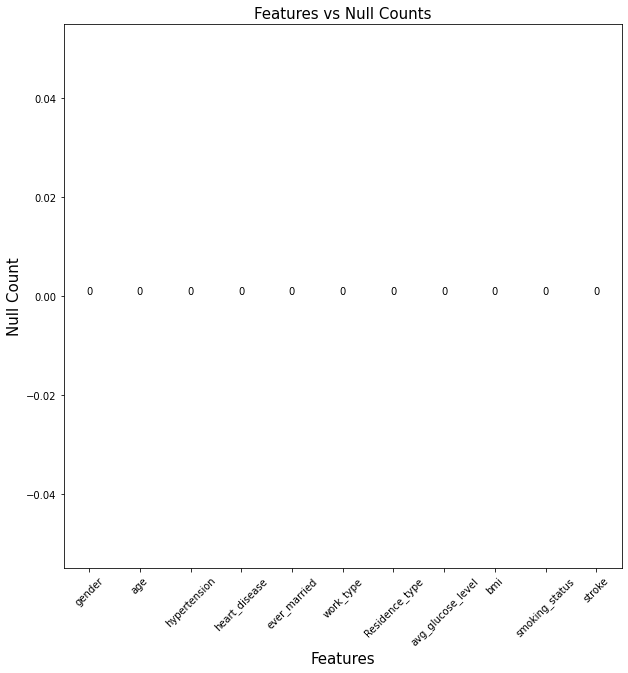

In [12]:
# plotting the features vs graph again to make sure there are 0 null values.
null_count2 = df.isnull().sum()
plt.figure(figsize=(10, 10))
ax = sns.barplot(x=df.columns, y=null_count2)
ax.bar_label(ax.containers[0])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Null Count', fontsize = 15)
plt.title('Features vs Null Counts', fontsize = 15)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 45)
plt.yticks(fontsize = 10)
plt.show()

## Exploratory Data Analysis:
During the exploratory data analysis, I utilized bar graphs and histograms to analyze the dataset and discovered the following insights:

Out of the 5110 people in the dataset, 249 or 4.87% had a stroke, while 4861 or 95.13% never had a stroke.

498 or 9.75% of the people in the dataset had hypertension, while 4612 or 90.25% did not.

276 or 5.4% of the people in the dataset had heart disease, while 4834 or 94.6% did not.

The probability of a male having a stroke was 5.11%, while the probability of a female having a stroke was 4.71%.

Married people and self-employed individuals had a higher probability of having a stroke, while stay-at-home parents and those who never worked had a lower probability.

Urban dwellers had a slightly higher probability of having a stroke compared to rural dwellers.

Former smokers had a higher probability of having a stroke compared to never-smokers or current smokers, and those with an unknown smoking status had the lowest probability.

The average age of a stroke victim was 68, while the average age of a person who never had a stroke was 42.

The average BMI of a stroke victim was 30.4, while the average BMI of a person who never had a stroke was 28.86.

The average glucose level of a stroke victim was 132.54, while the average glucose level of a person who never had a stroke was 104.8.

The analysis suggests that age, glucose levels, and BMI are inherent factors that could lead to having a stroke. Furthermore, where and how someone works appear to correlate with having a stroke, with married individuals and self-employed people having a higher probability.

249 or 4.87 % of the people in this dataset had a stroke.
4861 or 95.13 % of the people in this dataset never had a stroke.


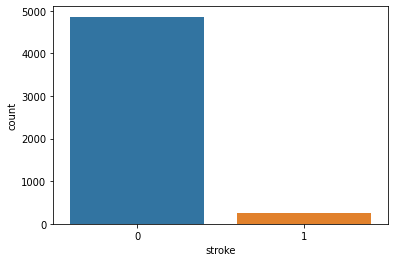

In [13]:
sns.countplot(data=df, x='stroke')
stroke_y = (len(df[df['stroke']==1])/len(df))
print(df.stroke.value_counts()[1], "or", round(stroke_y*100, 2), "% of the people in this dataset had a stroke.")
print(df.stroke.value_counts()[0], "or", round((1-stroke_y)*100, 2), "% of the people in this dataset never had a stroke.")

498 or 9.75 % of the people in this dataset have hypertension.
4612 or 90.25 % of the people in this dataset does not have hypertension.


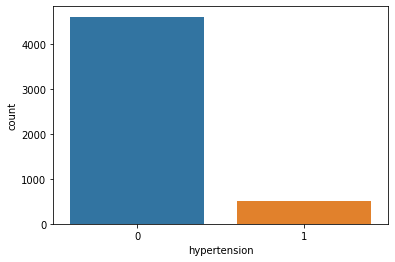

In [14]:
sns.countplot(data=df, x='hypertension')
hypertension_y = (len(df[df['hypertension']==1])/len(df))
print(df.hypertension.value_counts()[1], "or", round(hypertension_y*100, 2), "% of the people in this dataset have hypertension.")
print(df.hypertension.value_counts()[0], "or", round((1-hypertension_y)*100, 2), "% of the people in this dataset does not have hypertension.")

276 or 5.4 % of the people in this dataset have heart disease.
4834 or 94.6 % of the people in this dataset does not have heart disease.


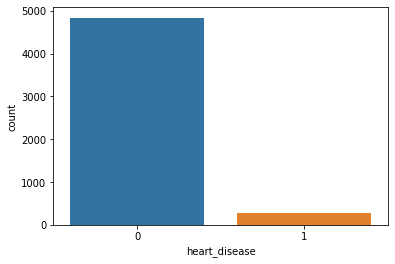

In [15]:
sns.countplot(data=df, x='heart_disease')
heart_disease_y = (len(df[df['heart_disease']==1])/len(df))
print(df.heart_disease.value_counts()[1], "or", round(heart_disease_y*100, 2), "% of the people in this dataset have heart disease.")
print(df.heart_disease.value_counts()[0], "or", round((1-heart_disease_y)*100, 2), "% of the people in this dataset does not have heart disease.")

<AxesSubplot:xlabel='age', ylabel='Count'>

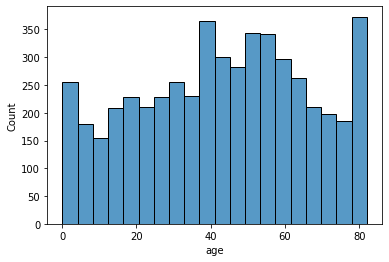

In [16]:
sns.histplot(data=df, x='age')

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

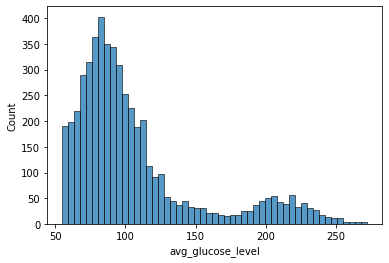

In [17]:
sns.histplot(data=df, x='avg_glucose_level')

<AxesSubplot:xlabel='bmi', ylabel='Count'>

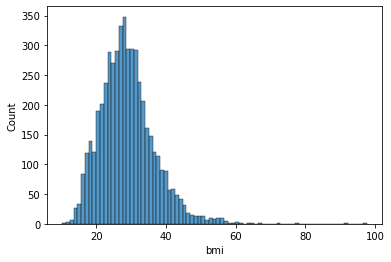

In [18]:
sns.histplot(data=df, x='bmi')

The probability of a male having a stroke is: 5.11 %
The probability of a female having a stroke is: 4.71 %


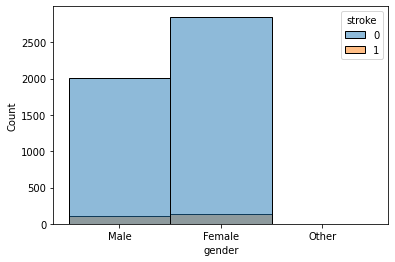

In [19]:
sns.histplot(data=df, x='gender', hue='stroke')
male_scount = len(df[(df.gender=='Male')&(df.stroke==1)])
male_count = len(df[(df.gender=='Male')])
percent_male = (male_scount/male_count)*100
female_scount = len(df[(df.gender=='Female')&(df.stroke==1)])
female_count = len(df[(df.gender=='Female')])
percent_female = (female_scount/female_count)*100
print("The probability of a male having a stroke is:", round(percent_male,2), "%")
print("The probability of a female having a stroke is:", round(percent_female,2), "%")

The probability of a married person having a stroke is: 6.56 %
The probability of a unmarried person having a stroke is: 1.65 %


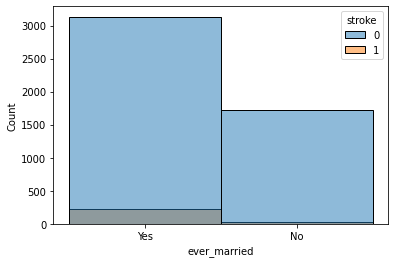

In [20]:
sns.histplot(data=df, x='ever_married', hue='stroke')
married_scount = len(df[(df.ever_married=='Yes')&(df.stroke==1)])
married_count = len(df[(df.ever_married=='Yes')])
percent_married = (married_scount/married_count)*100
unmarried_scount = len(df[(df.ever_married=='No')&(df.stroke==1)])
unmarried_count = len(df[(df.ever_married=='No')])
percent_unmarried = (unmarried_scount/unmarried_count)*100
print("The probability of a married person having a stroke is:", round(percent_married,2), "%")
print("The probability of a unmarried person having a stroke is:", round(percent_unmarried,2), "%")

The probability of a private company worker having a stroke is: 5.09 %
The probability of a self employed person having a stroke is: 7.94 %
The probability of a government worker having a stroke is: 5.02 %
The probability of a stay at home parent having a stroke is: 0.29 %
The probability of a person that never worked having a stroke is: 0.0 %


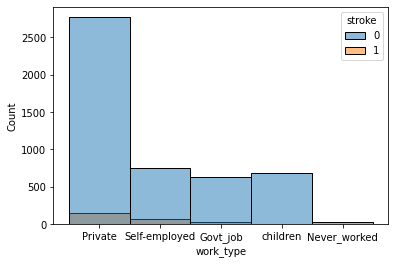

In [21]:
sns.histplot(data=df, x='work_type', hue='stroke')
private_scount = len(df[(df.work_type=='Private')&(df.stroke==1)])
private_count = len(df[(df.work_type=='Private')])
percent_private = (private_scount/private_count)*100
se_scount = len(df[(df.work_type=='Self-employed')&(df.stroke==1)])
se_count = len(df[(df.work_type=='Self-employed')])
percent_se = (se_scount/se_count)*100
gt_scount = len(df[(df.work_type=='Govt_job')&(df.stroke==1)])
gt_count = len(df[(df.work_type=='Govt_job')])
percent_gt = (gt_scount/gt_count)*100
ch_scount = len(df[(df.work_type=='children')&(df.stroke==1)])
ch_count = len(df[(df.work_type=='children')])
percent_ch = (ch_scount/ch_count)*100
nw_scount = len(df[(df.work_type=='Never_worked')&(df.stroke==1)])
nw_count = len(df[(df.work_type=='Never_worked')])
percent_nw = (nw_scount/nw_count)*100
print("The probability of a private company worker having a stroke is:", round(percent_private,2), "%")
print("The probability of a self employed person having a stroke is:", round(percent_se,2), "%")
print("The probability of a government worker having a stroke is:", round(percent_gt,2), "%")
print("The probability of a stay at home parent having a stroke is:", round(percent_ch,2), "%")
print("The probability of a person that never worked having a stroke is:", round(percent_nw,2), "%")

The probability of an urban person having a stroke is: 5.2 %
The probability of a rural person having a stroke is: 4.53 %


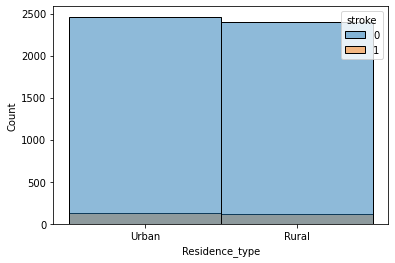

In [22]:
sns.histplot(data=df, x='Residence_type', hue='stroke')
urban_scount = len(df[(df.Residence_type=='Urban')&(df.stroke==1)])
urban_count = len(df[(df.Residence_type=='Urban')])
percent_urban = (urban_scount/urban_count)*100
rural_scount = len(df[(df.Residence_type=='Rural')&(df.stroke==1)])
rural_count = len(df[(df.Residence_type=='Rural')])
percent_rural = (rural_scount/rural_count)*100
print("The probability of an urban person having a stroke is:", round(percent_urban,2), "%")
print("The probability of a rural person having a stroke is:", round(percent_rural,2), "%")

The probability of a former smoker having a stroke is: 7.91 %
The probability of a never smoked person having a stroke is: 4.76 %
The probability of a smoker having a stroke is: 5.32 %
The probability of an unknown smoker having a stroke is: 3.04 %


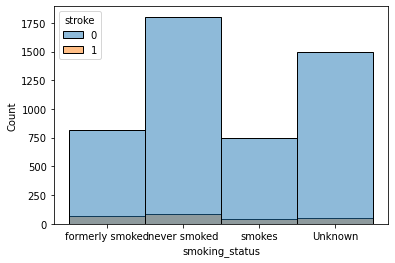

In [23]:
sns.histplot(data=df, x='smoking_status', hue='stroke')
fs_scount = len(df[(df.smoking_status=='formerly smoked')&(df.stroke==1)])
fs_count = len(df[(df.smoking_status=='formerly smoked')])
percent_fs = (fs_scount/fs_count)*100
ns_scount = len(df[(df.smoking_status=='never smoked')&(df.stroke==1)])
ns_count = len(df[(df.smoking_status=='never smoked')])
percent_ns = (ns_scount/ns_count)*100
sm_scount = len(df[(df.smoking_status=='smokes')&(df.stroke==1)])
sm_count = len(df[(df.smoking_status=='smokes')])
percent_sm = (sm_scount/sm_count)*100
un_scount = len(df[(df.smoking_status=='Unknown')&(df.stroke==1)])
un_count = len(df[(df.smoking_status=='Unknown')])
percent_un = (un_scount/un_count)*100
print("The probability of a former smoker having a stroke is:", round(percent_fs,2), "%")
print("The probability of a never smoked person having a stroke is:", round(percent_ns,2), "%")
print("The probability of a smoker having a stroke is:", round(percent_sm,2), "%")
print("The probability of an unknown smoker having a stroke is:", round(percent_un,2), "%")

The average age of stroke victim is: 68
The average age of a person never had a stroke is: 42


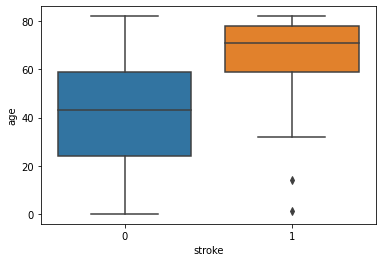

In [24]:
sns.boxplot(x='stroke', y='age', data=df)
print("The average age of stroke victim is:", round(df[(df.stroke==1)].age.mean()))
print("The average age of a person never had a stroke is:", round(df[(df.stroke==0)].age.mean()))

The average bmi of stroke victim is: 30.4
The average bmi of a person never had a stroke is: 28.86


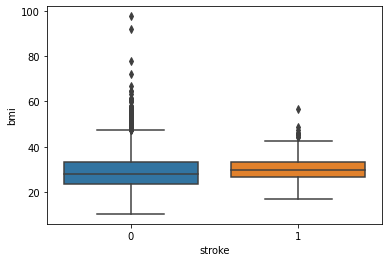

In [25]:
sns.boxplot(x='stroke', y='bmi', data=df)
print("The average bmi of stroke victim is:", round(df[(df.stroke==1)].bmi.mean(),2))
print("The average bmi of a person never had a stroke is:", round(df[(df.stroke==0)].bmi.mean(),2))

The average glucose level of stroke victim is: 132.54
The average glucose level of a person never had a stroke is: 104.8


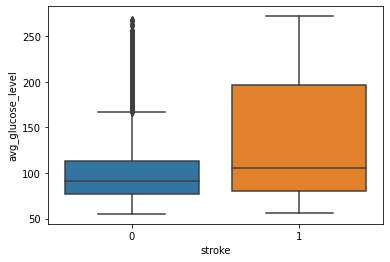

In [26]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=df)
print("The average glucose level of stroke victim is:", round(df[(df.stroke==1)].avg_glucose_level.mean(),2))
print("The average glucose level of a person never had a stroke is:", round(df[(df.stroke==0)].avg_glucose_level.mean(),2))

## Feature Engineering:
To improve the correlation matrix visualization and for modeling purposes, I converted all categorical and binary values into numerical values.

In [27]:
# using label encoder from sklearn to transform gender, ever_married, work_type, Residence_type and smoking_status
le = LabelEncoder()
gen = le.fit_transform(df['gender'])
em = le.fit_transform(df['ever_married'])
wt = le.fit_transform(df['work_type'])
rt = le.fit_transform(df['Residence_type'])
ss = le.fit_transform(df['smoking_status'])

df['gender'] = gen
df['ever_married'] = em
df['work_type'] = wt
df['Residence_type'] = rt
df['smoking_status'] = ss
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.60,1,1
1,0,61.0,0,0,1,3,0,202.21,31.04,2,1
2,1,80.0,0,1,1,2,0,105.92,32.50,2,1
3,0,49.0,0,0,1,2,1,171.23,34.40,3,1
4,0,79.0,1,0,1,3,0,174.12,24.00,2,1


<AxesSubplot:>

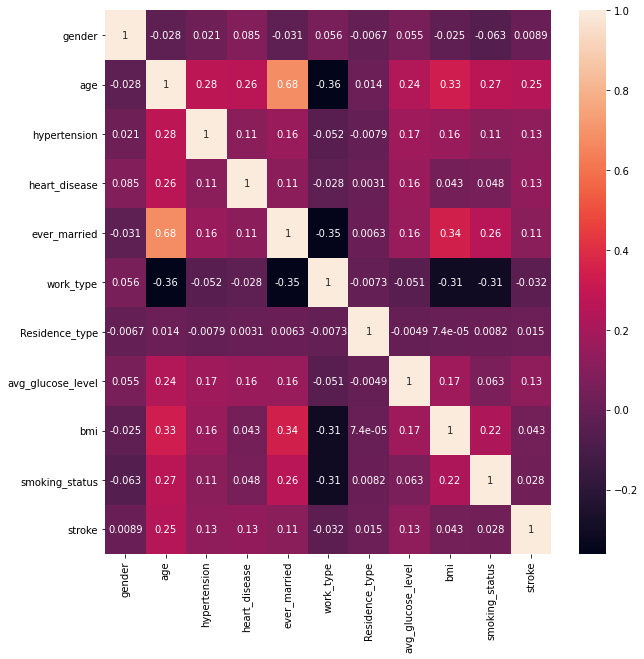

In [28]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)

From the correlation matrix, we can see that age, hypertension, heart disease and average glucose level are most correlated to having a stroke or not.

## Modeling:
During the modeling phase, I designated stroke as the response variable and all other features as predictor variables. I then assessed the performance of various classifiers to determine which one yielded the best results. To ensure the robustness of my analysis, I employed 10-fold cross-validation.

In [29]:
# X is the response and y is the features.
X = df.drop(['stroke'],axis=1)
y = df['stroke']

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [31]:
# using standardscaler function from sklearn to standardize the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [32]:
models = []
results = []
accuracy_scores = []
predictions = []
f1_scores = []

models.append(['Logistic Regression', LogisticRegression(solver='liblinear', multi_class='ovr')])
models.append(['KNearest Neighbor', KNeighborsClassifier()])
models.append(['Decision Tree Classifier', DecisionTreeClassifier()])
models.append(['Naive Bayes', GaussianNB()])
models.append(['SVM', SVC(gamma='auto')])
models.append(['Random Forest Classifier', RandomForestClassifier()])
models.append(['XG Boost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')])
models.append(['Ada Boost', AdaBoostClassifier()])
# looping each model to generate results
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append([cv_results.mean(), cv_results.std()])
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy_scores.append(accuracy_score(Y_test, y_pred))
    f1_scores.append(f1_score(Y_test,y_pred))
    print(name, ':')
    print('Cross Validation Mean Score:', round(cv_results.mean(),3),',', 'Standard Deviation:', cv_results.std())
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(Y_test, y_pred),2))
    print('Mean Squared Error:', round(metrics.mean_squared_error(Y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(Y_test, y_pred)),2))
    print('Accuracy Score:', round(accuracy_score(Y_test, y_pred),3))
    print('F1 Score:', round(f1_score(Y_test, y_pred),2))
    print('\n')


Logistic Regression :
Cross Validation Mean Score: 0.954 , Standard Deviation: 0.0007057484062171798
Mean Absolute Error: 0.06
Mean Squared Error: 0.06
Root Mean Squared Error: 0.24
Accuracy Score: 0.941
F1 Score: 0.0


KNearest Neighbor :
Cross Validation Mean Score: 0.953 , Standard Deviation: 0.002128127086183517
Mean Absolute Error: 0.06
Mean Squared Error: 0.06
Root Mean Squared Error: 0.25
Accuracy Score: 0.936
F1 Score: 0.0


Decision Tree Classifier :
Cross Validation Mean Score: 0.91 , Standard Deviation: 0.012056520123330425
Mean Absolute Error: 0.09
Mean Squared Error: 0.09
Root Mean Squared Error: 0.31
Accuracy Score: 0.906
F1 Score: 0.16


Naive Bayes :
Cross Validation Mean Score: 0.87 , Standard Deviation: 0.019068624070125727
Mean Absolute Error: 0.14
Mean Squared Error: 0.14
Root Mean Squared Error: 0.37
Accuracy Score: 0.865
F1 Score: 0.27


SVM :
Cross Validation Mean Score: 0.954 , Standard Deviation: 0.0007057484062171798
Mean Absolute Error: 0.06
Mean Squared Erro

## ROC Curve
The highest performance was achieved by Logistic Regression, which had an AUC score of 0.85.

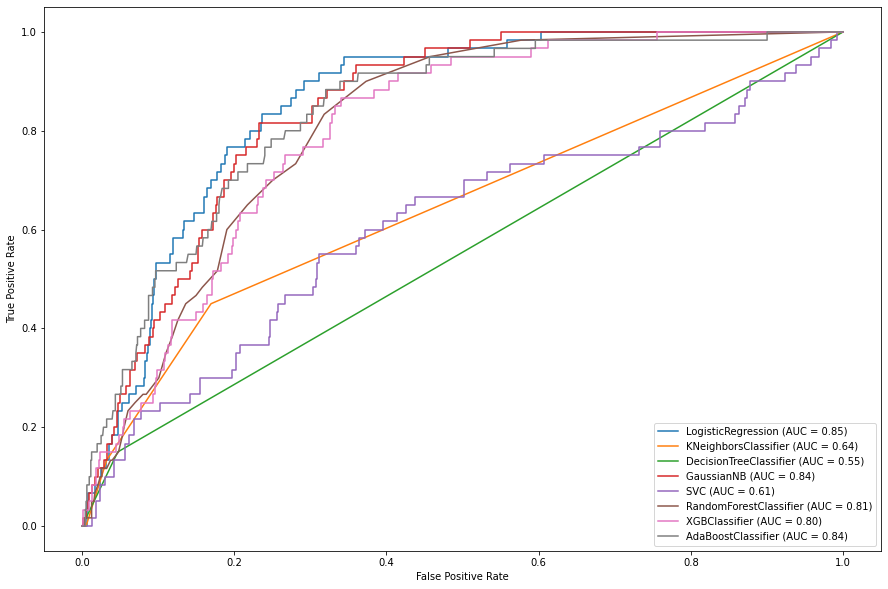

In [33]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
plot_roc_curve(models[0][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[1][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[2][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[3][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[4][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[5][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[6][1], X_test, Y_test, ax=ax)
plot_roc_curve(models[7][1], X_test, Y_test, ax=ax)
plt.show()

## Accuracy Score
I generated a plot displaying the accuracy scores of all the classifiers, and found that both Logistic Regression and SVM had the highest scores, with a value of 0.941. Ada Boost had the next highest score at 0.940.

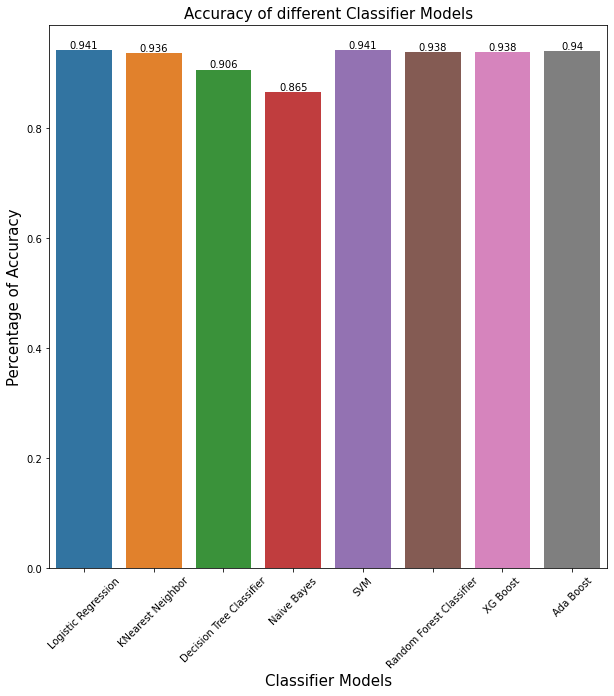

In [34]:
model_names = ['Logistic Regression','KNearest Neighbor','Decision Tree Classifier',
    'Naive Bayes','SVM','Random Forest Classifier','XG Boost','Ada Boost']
accuracy_scores = [round(score, 3) for score in accuracy_scores]

plt.figure(figsize=(10, 10))
ax = sns.barplot(x=model_names, y=accuracy_scores)
ax.bar_label(ax.containers[0])
plt.xlabel('Classifier Models', fontsize = 15)
plt.ylabel('Percentage of Accuracy', fontsize = 15)
plt.title('Accuracy of different Classifier Models', fontsize = 15)
plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 45)
plt.yticks(fontsize = 10)
plt.show()

## Confusion Matrix
The following are the confusion matrices for all classifiers.

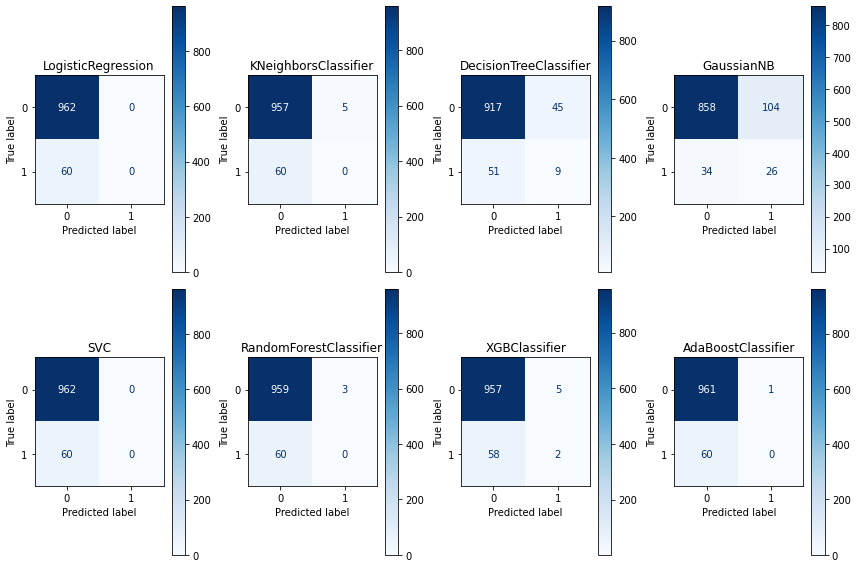

In [35]:
classifiers = []
for m in models:
    classifiers.append(m[1]) 
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,8))
for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, X_test, Y_test, ax=ax, cmap='Blues')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

## Results/Analysis:
Logistic Regression achieved the highest AUC of 0.85 and accuracy score of 0.941 among all the classifiers. Although it had some difficulty in correctly predicting true positive results, I still consider LR as the most suitable model for this dataset.

The F1 score returned zero for multiple models because of the unbalanced nature of the data, where there were zero true positives.

## Discussion and Conclusion:
The classifiers performed well in predicting the True Negative labels, but were less effective in predicting the True Positive labels due to the unbalanced dataset with more non-stroke than stroke cases. This imbalance affected the models' ability to correctly predict stroke cases. To improve performance, SMOTE (Synthetic Minority Oversampling Technique) can be used to give the minority data class more weight. Additionally, collecting more data on stroke patients can also help.

Overall, based on its high accuracy, AUC, and other metrics, Logistic Regression is the recommended model for this dataset.